## This script handles data cleaning for the future data csv

C:\Users\Dell Celestial\AppData\Local\Temp\ipykernel_10148\906031328.py:34: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(df[first_col], errors='coerce', infer_datetime_format=True)
C:\Users\Dell Celestial\AppData\Local\Temp\ipykernel_10148\906031328.py:50: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date'] = pd.to_datetime(df['date'], format='%Y-%m', errors='coerce', infer_datetime_format=True)
C:\Users\Dell Celestial\AppData\Local\Temp\ipykernel_10148\906031328.py:59: UserWarning: The argument 'infer_datetime_format' is depr

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   code       86 non-null     object        
 1   name       86 non-null     object        
 2   date       86 non-null     datetime64[ns]
 3   temp_mean  86 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 2.8+ KB
None
  code    name       date  temp_mean
0  MWI  Malawi 2015-07-01      22.90
1  MWI  Malawi 2016-07-01      22.65
2  MWI  Malawi 2017-07-01      23.15
3  MWI  Malawi 2018-07-01      23.52
4  MWI  Malawi 2019-07-01      22.46

Missing values per column:
 code         0
name         0
date         0
temp_mean    0
dtype: int64

Duplicate date entries: 0
                                date  temp_mean
count                             86  86.000000
mean   2057-12-30 11:43:15.348837376  24.066628
min              2015-07-01 00:00:00  22.4100

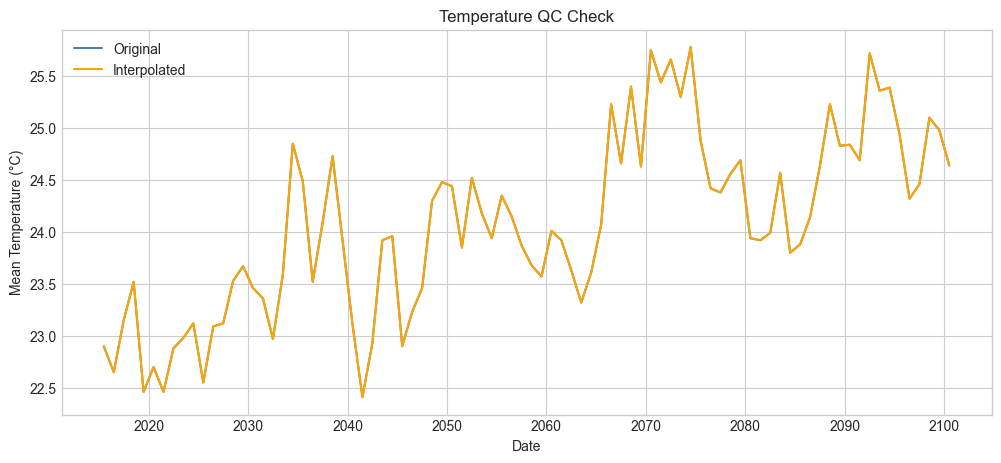

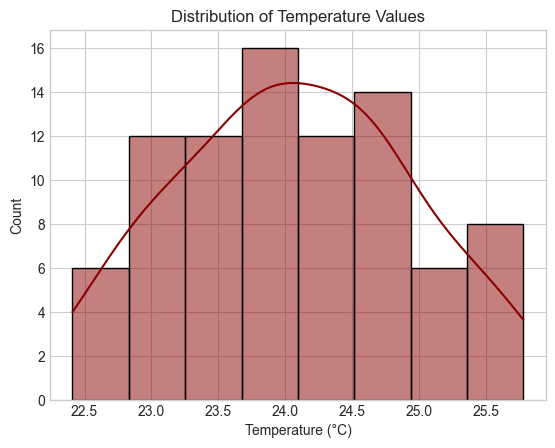

Cleaned data saved to: ..\data\processed\mean_future_temp_clean.csv

QC Summary:
Original rows: 86
After cleaning: 86
Missing after interpolation: 0


In [1]:
#1. Setup 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


# Configure plotting style
plt.style.use('seaborn-v0_8-whitegrid')


# Define file paths
RAW_PATH = Path('../data/raw/future_mean_temp.csv')
PROC_DIR = Path('../data/processed/')
PROC_DIR.mkdir(parents=True, exist_ok=True)


#2. Load Data

# Read CSV without forcing parse_dates to avoid errors if the column name differs
df = pd.read_csv(RAW_PATH)

# Try to find a date-like column (common names)
date_col = None
for col in df.columns:
	if col.lower() in ['date', 'datetime', 'time', 'timestamp']:
		date_col = col
		break

# If no common name found, try to infer from the first column by parsing to datetime
if date_col is None:
	first_col = df.columns[0]
	parsed = pd.to_datetime(df[first_col], errors='coerce', infer_datetime_format=True)
	if parsed.notna().sum() / len(parsed) > 0.8:
		date_col = first_col

if date_col is None:
    # Assume wide-format (years as columns). Melt to long with 'date' and 'temp_mean'
    # Use object-typed columns (e.g., 'code','name') as id_vars if present
    id_vars = [c for c in df.columns if df[c].dtype == object]
    if len(id_vars) == 0:
        # fallback: keep the first column as id
        id_vars = [df.columns[0]]
    value_vars = [c for c in df.columns if c not in id_vars]

    df = df.melt(id_vars=id_vars, value_vars=value_vars, var_name='date', value_name='temp_mean')

    # Try to parse date strings like '1950-07' -> year-month
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m', errors='coerce', infer_datetime_format=True)

    # Drop rows without a parsed date or without a value
    df = df.dropna(subset=['date', 'temp_mean']).reset_index(drop=True)

    # Set detected date column
    date_col = 'date'

# Parse the detected date column
df[date_col] = pd.to_datetime(df[date_col], errors='coerce', infer_datetime_format=True)
n_unparsed = df[date_col].isna().sum()
if n_unparsed > 0:
	print(f"Warning: {n_unparsed} rows could not be parsed as dates in column '{date_col}'. They will become NaT.")

# Rename to 'date' for consistency
if date_col != 'date':
	df = df.rename(columns={date_col: 'date'})

df.sort_values('date', inplace=True)


print(df.info())
print(df.head())


#3. Basic Checks 

# Check for missing values
missing = df.isna().sum()
print("\nMissing values per column:\n", missing)


# Check for duplicates
duplicates = df.duplicated(subset='date').sum()
print(f"\nDuplicate date entries: {duplicates}")


# Basic statistics
print(df.describe())


#4. Outlier and Range Check


def flag_outliers(series, lower, upper):
	return ((series < lower) | (series > upper))


# Flag unrealistic temperature values (°C)
df['temp_outlier'] = flag_outliers(df['temp_mean'], -20, 50)
print(f"Outlier count (temp_mean): {df['temp_outlier'].sum()}")


#5. Handle Missing Data


# Interpolate small gaps (linear method)
df_clean = df.copy()
df_clean['temp_mean'] = df_clean['temp_mean'].interpolate(method='linear', limit=3)


#6. Plot Quick Diagnostics


fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df['date'], df['temp_mean'], color='steelblue', label='Original')
ax.plot(df_clean['date'], df_clean['temp_mean'], color='orange', label='Interpolated')
ax.set_title('Temperature QC Check')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Temperature (°C)')
ax.legend()
plt.show()


# Histogram check
sns.histplot(df_clean['temp_mean'], kde=True, color='darkred')
plt.title('Distribution of Temperature Values')
plt.xlabel('Temperature (°C)')
plt.show()


#7. Save Cleaned Data


output_file = PROC_DIR / 'mean_future_temp_clean.csv'
df_clean.to_csv(output_file, index=False)
print(f"Cleaned data saved to: {output_file}")


#8. Summary


print("\nQC Summary:")
print(f"Original rows: {len(df)}")
print(f"After cleaning: {len(df_clean)}")
print(f"Missing after interpolation: {df_clean.isna().sum().sum()}")